# Music Generation Using Char-RNN

In this tutorial we will be training a char-RNN on multiple music files represented in ABC notation (https://en.wikipedia.org/wiki/ABC_notation). We train a char-RNN as a character-level language model. The following diagram shows the application of a char-RNN for character prediction at each time-step.

<img src="https://i.imgur.com/ZS1iuCh.png" style="height:100px; width:100px"></img>

An example RNN with 4-dimensional input and output layers, and a hidden layer of 3 units (neurons). This diagram shows the activations in the forward pass when the RNN is fed the characters "hell" as input. The output layer contains confidences the RNN assigns for the next character (vocabulary is "h,e,l,o"); We want the green numbers to be high and red numbers to be low. 
Source : http://karpathy.github.io/2015/05/21/rnn-effectiveness/

In [1]:
import tensorflow as tf
import numpy as np
import urllib
import os.path
import urllib.request
import matplotlib.pyplot as plt

/Users/uksrivastava/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The following function reads all the input characters in the text file and preapres a vocabulary of the unique characters ```i2c``` (index to character) and a reverse mapping ```c2i```. It incodes the text file as a list of indices in the vobulary for each character in the text file. You can call this function and print i2c, c2i and data to understand the data structures used.

In [2]:
def load_data(file_path="input.txt"):
    if not os.path.isfile(file_path):
        urllib.request.urlretrieve("https://paarthneekhara.github.io/input.txt", filename=file_path)
        print("downloaded file")
    f = open(file_path)
    raw_data = f.read()
    f.close()
    vocab = {}
    vocab = {ch : True for ch in raw_data}

    i2c = [ch for ch in vocab]
    c2i = {ch : i for i, ch in enumerate(vocab)}

    data = [c2i[ch] for ch in raw_data]
    
    return data, i2c, c2i

In [3]:
data, i2c, c2i = load_data()

In [4]:
print(c2i)

{'<': 0, 's': 1, 't': 2, 'a': 3, 'r': 4, '>': 5, '\n': 6, 'X': 7, ':': 8, '1': 9, 'T': 10, ' ': 11, 'L': 12, 'M': 13, 'o': 14, 'n': 15, 'f': 16, 'i': 17, 'e': 18, 'Z': 19, 'c': 20, '/': 21, 'u': 22, 'g': 23, '?': 24, 'p': 25, 'h': 26, 'l': 27, 'B': 28, 'E': 29, 'O': 30, 'N': 31, '-': 32, '2': 33, '0': 34, '5': 35, '7': 36, '4': 37, 'P': 38, 'b': 39, 'v': 40, 'm': 41, '@': 42, '.': 43, '8': 44, 'Q': 45, '=': 46, '6': 47, 'F': 48, 'G': 49, 'A': 50, '{': 51, '}': 52, '|': 53, 'D': 54, 'C': 55, '3': 56, ',': 57, '_': 58, 'd': 59, 'S': 60, 'V': 61, '(': 62, 'I': 63, ')': 64, 'K': 65, 'j': 66, 'z': 67, 'w': 68, 'x': 69, ']': 70, '"': 71, '!': 72, '+': 73, '[': 74, "'": 75, 'U': 76, '9': 77, '^': 78, 'R': 79, '\\': 80, 'y': 81, 'H': 82, 'q': 83, 'J': 84, 'W': 85, 'k': 86, '~': 87, '\t': 88, 'Y': 89, '*': 90, '#': 91, '&': 92}


The function below will be used during training to get a sentence (list of 25 contiguous characters) from the data. The target sentence is offset from the source sentence by 1 index. Refer to the diagram above to understand why.

In [5]:
def get_sentence(sentence_index, sentence_length, data):
    si = sentence_index * sentence_length
    ei = min(si + sentence_length, len(data)-1)
    source = np.array([data[si:ei]], 'int32')
    target = np.array([data[si+1:ei+1]], 'int32')

    return source, target

We define our language model below. The model is an implementation of the char-RNN described above. Instead of a simple char-RNN we use an improved model called LSTM which is popular for language modelling tasks. 

In [6]:
class Model:
    def __init__(self, options):
        self.embedding_matrix = tf.get_variable('embedding_matrix', 
                [options['vocab_size'], options['hidden_size']],
                initializer=tf.truncated_normal_initializer(stddev=0.02))
        self.options = options

        self.lstm_init_value = tf.placeholder(
                tf.float32,
                shape=(None, 2 * options['hidden_size']),
                name="lstm_init_value"
            )

    def forward_pass(self, sentence):
        sentence_embedding = tf.nn.embedding_lookup(self.embedding_matrix, 
            sentence, name = "sentence_embedding")
        cell = tf.nn.rnn_cell.LSTMCell(num_units=options['hidden_size'], state_is_tuple=False)
        outputs, last_states = tf.nn.dynamic_rnn(
                cell=cell,
                dtype=tf.float32,
                initial_state=self.lstm_init_value,
                inputs=sentence_embedding)
        outputs = tf.reshape(outputs, shape = (-1, options['hidden_size']))
        logits = tf.layers.dense(outputs, self.options['vocab_size'])
        self.last_states = last_states
        return logits

In [7]:
# IMPLEMENT THIS FUNCTION
# activations is a tensor of shape (Vocab Size,)
def sample(activations, temp):
    # Implelemnt this function
    if temp == 0.0:
        sample = np.argmax(activations)
    else:
        scale = activations / temp
        exp = np.exp(scale - np.max(scale))
        soft = exp / np.sum(exp)

        sample = np.random.choice(len(soft), p=soft)
    return i2c[sample]

In [8]:
def generate_sample(T = 1.0, sample_length = 1000):
    # seed to start with
    source_np = np.array( [[c2i['<'], c2i['s'], c2i['t'], c2i['a'], c2i['r']]], dtype = 'int32')
    generation = '<star'
    init_state =  np.zeros((1, 2 * HIDDEN_SIZE))
    for i in range(sample_length):
        if i != 0:
            init_state = next_hidden
        
        logits_np, next_hidden = sess.run([logits, model.last_states], 
            feed_dict={
                input_tensor : source_np,
                model.lstm_init_value : init_state
            }
        )

        ch_sampled = sample(logits_np[-1,:], T)
        generation = generation + ch_sampled
        
        source_np = np.array( [[c2i[ch_sampled]]])
        
    return generation

In [9]:
MAX_EPOCHS = 5 
HIDDEN_SIZE = 200 # Hidden Units in the LSTM
SENTENCE_LENGTH = 25 # Sentence Length Used In Training
LR = 0.0004 # Learning Rate
TEMP = 1 # Temperature parameter used to control stochasticity in sampling
SAMPLE_EVERY = 100 # Generate a sample every x iterations
SAMPLE_LENGTH = 100 # Max Length of sample to be sampled from the model
BATCH_SIZE = 1

In [10]:
data, i2c, c2i = load_data()

input_tensor = tf.placeholder(tf.int32, [BATCH_SIZE, None])
target_tensor = tf.placeholder(tf.int32, [BATCH_SIZE, None])

options = {
    'vocab_size' : len(i2c),
    'hidden_size' : HIDDEN_SIZE,
    'sentence_length' : None
}   

model = Model(options)
logits = model.forward_pass(input_tensor)
target_tensor_flat = tf.reshape(target_tensor, shape = (-1,))
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = target_tensor_flat, logits = logits))


train_op = tf.train.AdamOptimizer(LR).minimize(loss)


In [11]:
print ("Vocab")
print (i2c[0:50])
print ("Data")
print (data[0:50])


Vocab
['<', 's', 't', 'a', 'r', '>', '\n', 'X', ':', '1', 'T', ' ', 'L', 'M', 'o', 'n', 'f', 'i', 'e', 'Z', 'c', '/', 'u', 'g', '?', 'p', 'h', 'l', 'B', 'E', 'O', 'N', '-', '2', '0', '5', '7', '4', 'P', 'b', 'v', 'm', '@', '.', '8', 'Q', '=', '6', 'F', 'G']
Data
[0, 1, 2, 3, 4, 2, 5, 6, 7, 8, 9, 6, 10, 8, 11, 12, 3, 11, 13, 14, 15, 2, 16, 3, 4, 17, 15, 18, 6, 19, 8, 10, 4, 3, 15, 1, 20, 4, 17, 2, 11, 18, 2, 21, 14, 22, 11, 20, 14, 4]


In [12]:
epoch_losses = []
iterations = []

sess = tf.InteractiveSession()
tf.initialize_all_variables().run()
init_state =  np.zeros((1, 2 * HIDDEN_SIZE))
for epoch in range(MAX_EPOCHS):
    iter_losses = []
    for sentence_index in range((int)(len(data)/SENTENCE_LENGTH)):
        source, target = get_sentence(sentence_index, SENTENCE_LENGTH, data)
        if sentence_index != 0:
            init_state = next_hidden

        _, loss_val, next_hidden = sess.run([train_op, loss, model.last_states], 
            feed_dict={
                input_tensor : source,
                target_tensor : target,
                model.lstm_init_value : init_state
            }
        )
        
        iter_losses.append(loss_val)
        
        if sentence_index % SAMPLE_EVERY == 0:
            print("\n\n*****************************\n\n")
            print (sentence_index, epoch, loss_val,"\n")
            sample_generation = generate_sample(T = TEMP, sample_length = SAMPLE_LENGTH)
            print (sample_generation)

    epoch_losses.append(np.mean(iter_losses))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


*****************************


0 0 4.533352 

<starR0t.vW3)(.3_082DHM-2Q@d-V.oR))7H|YaF_x&o3{8XyD:Gc2jph._]3XzV]nnz#)S~5,gFtW6!7T
kx{g#fNhsHldbAN{	e"}A


*****************************


100 0 2.5174923 

<star[z}G&Fh)3:pl"ol(f y_eBB2   E   
D  o2 eni 2    c dG F2 E/Tc m    2V|  4e 2c d2K|B  de|etc2 l  d|2 d2


*****************************


200 0 2.8075852 

<star	?CYe.N}Pe_Hgf/sfa2s|d!e/er t/
/T!:/ 2(|2{/ t.BB/(  |// # |/ =cB.5c: /(!d2/c/ ( { n| B( //dc(f   d |


*****************************


300 0 2.3045018 

<star)mv2wzS]UG z2)/-B/|/_ /f|c/g B//i|g/)B// //A / lcgc/./d//==/A2t/ | gg/ c/ "/B(/ ///:g4//f/(fG//  f//


*****************************


400 0 2.8912008 

<starAoNLlgzzGG-<HOd=<Hu\oA0ym[wkTvHs~\s>	uWJm	JJkWT9K6*9NWm8@7J5.y^uJ'N#J6k	#&tqL	HcZ*X#9Ws1&>xUqJUw0HyL


*****************************


500 0 3.54295 

<starP5w##NyW	y@	QU/@<kkpPjm.kw9H\#zwz*	'OSqk^v#rqZ!-Y@Ws&\qkHA*qy	WH_ *#Er#"mn9y*',R1y,q



*****************************


5000 0 1.7732954 

<starou"Mi?al"celle
N:A2
L:iransesct]
O: Frainees de Ra t/8ouse eou M?'4))
O:P:2//8
K:a
V:Vanascr
<start:


*****************************


5100 0 3.43058 

<staralle@frig
M:G/4
V:1/4=25
F22BF | f2d/>c G3 | E2G | BG/ G3 | Gm((c2g/2^c/c/ | " c>dg | f2eec | age/ |


*****************************


5200 0 1.6258247 

<star Bou il 1o?l"q -a B A|
CBAb | w'a ge | ddc | gg/E/2 B, | 
G."G/2 G|A7
G|C9 "A"Bd :
Bf_|=1 "GEGB2 cAB


*****************************


5300 0 1.5326065 

<starnla ttoujwon mail-ce
<sIntr Bictounce
R:Trard d
 tourvalotigneiree. er dorrig?nirier dilarfa Ginsari


*****************************


5400 0 1.6592038 

<stare_dei) MarGiei dul
<ensoviet fu p'vau
Obounte u'reus Ra?len
W:V9fsnendu](
:Tradessu 
R:Tuhove
Z:Tram


*****************************


5500 0 2.6563714 

<star:
<cnd>
<sti vit et/ou corrig? par Mies ctou le lailte 
W:Fnete
Z:Transcrit et/ou cor fourig? pareg 


*****************************


5600 0 1.86656



*****************************


10200 0 2.6326647 

<staripoelB>
M:Ed|
K:G
Ad|AAbB DBdB|
D2FG G2E A2:|
|:cdg g2ga||
fec dBAG|cEGA GAGF:|
cAAc A2d2 F2:|
<end>


*****************************


10300 0 1.7839606 

<star tare
<sthou Arre Hartipime 1 zonssin
Z:ig:hn-hogrnain torgiongan
H:Jede
R:Ocdeien obdmaine, lave _i


*****************************


10400 0 1.9981163 

<starw:7
XV:2
K:B
H:Dfveesedf def|gced edfdB|B2de c2BA|F2Ac de^c|(cdef gdce|(3agf gdBB|GBAB AcAG|AAGG GFF


*****************************


10500 0 2.6567874 

<start:M
X:41
T:Porn Hornpipans Pasr alno "3eaulsi ote tlu Hollapd Iry
H:Pe qh
Z:inschorn ?fy-22
M:C|
K:G


*****************************


10600 0 1.3046083 

<start:
X:29
K:Ghariengson andhon , torne
T:helanpriat Fnviinatog
H:Snanopin" Giro Dnateansscolerep'pin -


*****************************


10700 0 2.4512897 

<start>
G:C|[G>d,f a2 (3Bde a2~|2 (3dee d2 (3BGB | dBdg Bded :|2 dddc BABd|d2 A3Bc|AGGF G2 (3Bcd|cAB2 Bdf


*****************************


10800 



*****************************


15400 0 2.4219003 

<star
X:8
T:Jay Keponan Hay
H:Mecka eel Ainnais, Us waciret Sangates, The
R:murka
D:Pohn Bctres: The Cuvo


*****************************


15500 0 1.6960502 

<star
H:3/e de vertiond:
L:Or tree Coon tlorerma, #5
R:hmel"7
D:Prigh porke the Lergon ine Gor.
R:polke
H


*****************************


15600 0 1.6480293 

<star
M:D|1 FGEG EGED ||
|: ed^c_B B2dg|edBd BG~D|E2A2 cded|dcBG GE~E2:|
|:Bdef d>df|~g3e cBef|
agfd efed


*****************************


15700 0 1.3518463 

<star
H:AdB cEEG E3d3 :|
<end>
<start>
X:2
T:Nevon Rogdh
H:Neels: Us Opecled ca
R:poll'z
H:Deslagan: Seea


*****************************


15800 0 1.4926894 

<star
|:ABGB G3BA:|
|:~(33BE GEf2|fgeg ageg|gfga agge|d2BA B2AG|
(3cBc B2AB|dgfg bged|eged BAFD||
|:dBcd 


*****************************


15900 0 0.7151119 

<start>
D:Mevipy nested tols ond of blecolla
":"The un of Dann\a maidey Goontlet & Aungoow"2rost 18meet o


*****************************


16000 



*****************************


500 1 2.4255884 

<staration plareat ta-coustewvon crsipelle
Z:Crafhiv? mare@tag?
M:5/8
K:D
c2G G2B | c2 d2A | f4- | g2g | 


*****************************


600 1 1.86305 

<start>
X: 1 4 G3B (2Bde | defdd | e3 :ab agfe | c2 BGABse | d2 edef | ec Ba=Bc | e2 d3 | cBg dB{ge | fA>


*****************************


700 1 0.38846293 

<start>
X:84
T:Largye Men Bous'n5
W:.bid ef #17 #459-64
Z:Transcrit et/ou corrigela:ur
M:C/4
L:1/8
K:C
(A


*****************************


800 1 3.0936573 

<starvat>et>
X:3
K:A
T:Qecp?ro
W:I MacG
Z:Transcrit et/ou cervouviele@free.fr
M:2/2
K:G
cB c2 | cc B2 | c


*****************************


900 1 1.3199832 

<start>
M:F|-8 GBE|F2B/2|||
|: f2 cd | {b2z | T3 (c/e/f/) |
=B/c/=B cF | B3 c2z |
G2 Bo!S | d>c>ed | cB z


*****************************


1000 1 1.6071132 

<start>
X:23
T:Launvet?
C:Vig?are vervide
Z:Transcrit et/ou corraig? pbarig? fivarianiele<er
M:4/4
K:Gm
A


*****************************


1100 1 0.51299596 



*****************************


5700 1 2.152976 

<start>et/or detrouvielle@frue.cr
M:6/8
L:1/8
K:G
A/f/d/e/|d2c B^c|A/G/d/c/ ed/c/|dg ed/2c/2|[(cBA z/2c/2


*****************************


5800 1 0.023248082 

<start>
X:7
T:ge dro wule
R:Ita?ce
AA Mam"de noute di du?b'en N'and pallin
Z:Transcrt et/ou G:
M:2/4
Q:1/


*****************************


5900 1 0.8403233 

<start?
[L:7/8=16
K:Fa"d/e/f/d/e/c/|dc f3/2A/2B/3/3|] Preaf
ff ag | c2c ef | fg gg ec | _e2 "ede | cB c2 


*****************************


6000 1 1.3067693 

<start>et/ =ccitto:
M:4/8
Q:1/80
F ABA | B2c BG|AB cBc | cBc ABc |
(3G/A/) | Ad z2 |
P:Priod.fe
| "C""cd 


*****************************


6100 1 0.9764816 

<start!: EABGB c2c2 A2G2 | A4c2 | [CaLeg fe | d3 def | edc2 e2 cce | e2e e2d2 | d2e2 dcde | fede) | cBABB


*****************************


6200 1 1.2202777 

<starty]T@beabgn!b2a tes binton  thous thivbpai tosti vam Amus el gut?, Trraschesor",5 ,7, pux'ains cais,


*****************************


6300 1 1.91



*****************************


10900 1 1.2090415 

<start>
X:349
T:O'Kesordykefirg
Z:id:hn-hornpipe-74
M:C|
L:1/8
K:D
(3Bf)|
e2ef abag|afb2 afed|cAdA a2re|d


*****************************


11000 1 1.3105148 

<start>
H:Deussish oB Bo le wheradef
Z:id:hn-hornpipe-89
M:C|
K:D
DF|GA AGFE| A2GF EGD2|dddc BABc|d^cde f


*****************************


11100 1 0.9235254 

<start>:
X: 150
K:D
dge|Afga gEcF|G2GA BGAB|DG FGAF EFGA|~B2A2 (3Fdc (3dcB|(3ABG EB (3cde|fgde fdcd|egec 


*****************************


11200 1 1.0555475 

<start>
H:hat paghlay wall wix
W:ang ol cloo2/.
G:Padtt Mamerik
D:Marec'in: bayt allo pay Fu als: wi?hila


*****************************


11300 1 0.36077332 

<start>
X: 40
T:Keln's Wohpipoday
W:Bran of the Kanin:2
H:Dernan GEposin's
H:See a Froorn 6/81
M:C|
K:G
:


*****************************


11400 1 1.7392102 

<start>
X:28
T:Ant Breahere Hornpipe
D:Sorell Was Syent
D:Madly Priamell Ne
Z:id:hn-hornpipe-
R:h:cornpip


*****************************


11500



*****************************


16100 1 1.3158505 

<stark>
X:38
T:Mirtinge
T:Linwes.
T:Kegins shig.
D:woc geglery Dudring "The Gnandir to Modred nwiver's
R:


*****************************


16200 1 0.70422137 

<start
X:4
T:Destiny 
Z:id:hn-reel-24
M:C|9
P:sontel
D:B>A cBee|dcBc efie|d2aB eAcA||
ABce fedc|Bcdc d2dc


*****************************


16300 1 1.1154317 

<start":
T:Ghillpall
R:4
Hce Bce EFBg | eBdB BGBA | G2EF G2cd | ecAd efge | fedB AGFE :|2 ~G3E A2||
<end>


*****************************


16400 1 1.5760759 

<star tusse orrips Furkiellears, #8
T:Mare Dinereds ahe &n age are "The Haj 1174 pars Mife
D:Mutt of the 


*****************************


16500 1 1.5089264 

<start ollatt to the froms reell.
H:Thille Sa Roor
R:reel
D:Cone to the of thild te, #85
R:ree
D:Choek Bo


*****************************


16600 1 1.5069178 

<start>
D:BaAlfy.
D:Gary Pery Dene127. (199b-118156)
Z:vishisce Car
S:version vears on the fancers, The
R


*****************************


16700



*****************************


1200 2 1.876229 

<start>
X:22
T:Per?ro dour?pam,
C:Pancelouration Douckiod" Seeufiesle
R:Vedouriarietion (193
A:Eddile Qua


*****************************


1300 2 2.5618827 

<startoug@gage|
M:3/4
L:2/2
[]:1/8
K:Bb
K:G0
V:2
D2DE | A2c2 c2 | B2z2 :|
S son! son j fend mamons orciso


*****************************


1400 2 0.11121443 

<starte@frcet,
M:C|9
I nan  d> !c Vas la cou-tomf Mc}7_1z nam!us-magrra to Sam tou 
O:Frax.
O:Frajic
H:F 


*****************************


1500 2 1.6128364 

<start>
X:31
T:Tubri?rae.
Z:Ranscrit et/ou crig. barrins Carpaition Seele
M:2/4
L:1/1
Q:"Transoutle neupo


*****************************


1600 2 1.1297683 

<starto>matloumat"og? Jamou sines Gina Salps se tar Ails our bar Gu?re
R:Danse vicled ansominel difflet a


*****************************


1700 2 0.5996595 

<start>
X:23
T:La Bmast
O:France
C:Trad.
F:Pranfe
A:Provence
C:Tramsclire
Z:Tarsct et1o parse9
O: Frane A


*****************************


1800 2 1.976



*****************************


6400 2 0.97217894 

<start>
X150
T:Rigetilasc
C:Rice ditly
R:Dmasche
s:Changes (Hillois
C:Blergucairo_N
Z:Pour toupe obsarvan


*****************************


6500 2 1.7980261 

<start>
X:14
T:les Vavers E Granchse
C:J. Chive Ad, Rowbabs
R:Scottishe - Alpans
R:Schottische
S:Carniny 


*****************************


6600 2 1.2515787 

<start>
X:1
T:Le Koarnes Be Jupiekeche
T:Re_ted Aranle (=umpercy
L:2/4
eff Ledc |B2gf edcd | e2ege |1d2 d


*****************************


6700 2 2.0899467 

<starto!ce|7
c/c/d/e/) g:|
w:Scostred
R:Bourree
C:Le Lonctaulles pestestard inaltut zur tubo ren
R:Bourre


*****************************


6800 2 1.1229702 

<startto@bel ue Siariginalla 4 anx 2 las thancre
K:Bu
C:Proneece
A:Pridiebs Quim? cook -tr2 paser ddan-ti


*****************************


6900 2 1.1007382 

<star>
X: 10
T:ch' chottile din
Z:ididhdy Bolkabl
C:Tarot: douli?re "Davane bave
Z:Comall Chrinee-2l, Cla


*****************************


7000 2 1.93



*****************************


11600 2 0.8511101 

<starn StrmathAeppe-enttel serstipe, The
T:Sumolandy: Iy Liy M\'MadlOy'e Woux ono Mornin
Z:id:hn-hornpipe


*****************************


11700 2 0.83653975 

<start:Tavet/or mas (1538)
Z:id:hn-hornpipe-88
M:C|
K:D
GA|BG3B dGBd|B2gd BAGB|DGBG AGEF|DABc dcBA|GFEF G


*****************************


11800 2 0.9490989 

<starth>
X:99
T:Ee comnyy Lige, The
R:hornpipe
H:See also played in Fanndy
Z:id:hn-hornpipe-94
M:C|
K:D
|


*****************************


11900 2 1.1344098 

<start>
X:5
T:Tigeld hestle bay Z:id in Hory hamm of ao h'y olpidy and sildhamel The
R:hornpipe
D:Jies Ho


*****************************


12000 2 1.6267279 

<start>
X:1/4
T:numem ander, The
R:jiaj
D:Then ther the Reilly wunne, The
R:jig
|: G7 (3ABA| GED cBd | DE


*****************************


12100 2 1.2606635 

<start>
X:11
T:Pink ithony. Nove th Muineenster.", #87
R:jig
W:Samen & Peadk Pitt I Andow's Weath thish o


*****************************


12200



*****************************


16800 2 1.321666 

<startons:
f>ed|edBA BcBA|1 FABG BG~G2 :|2 BGBd ~g3e||
d2~B2 ~f3B|ABAG FAHB|AF~E2 DBAF|FABF EFAF|G2BG BGA


*****************************


16900 2 1.6204109 

<starhutl
~f/e/d/c/ Adec|1 dgfg fdgA:|
|:B2cd cdcd|ceec ecAd|cdec ~A2fg|afec dBGB||
P:variatiCh7
|:~G3B ~


*****************************


17000 2 1.2377782 

<start>
D>CED FDCE|GBde fdcd|cBAD ADdB|AGFA BEgB|1 dBAG FDD2:|2 dfba bagf|edde fdAF|
dcAG FDED||
F2AB cde


*****************************


17100 2 1.5270447 

<start oor in (1p-)
D:Ha glaighttimes: The "Kmorye: and Fered wwat in cow
R:reel
C:Pet the catnedz nppper


*****************************


17200 2 0.5715465 

<starhoth
dg/g/a/g/:|2 a2 eg/a/g/e/|df/a/g/e/ d2 BA||
<end>
<start>
X:90
T:Lick is the Firtmatish, The
T:


*****************************


17300 2 1.2634968 

<start>
Z:id:hn-recop-34
M:C|
K:D
AD|AGEF EAFA|D2FA dcBA|GBcd efge|
B2dB cBAB|cAGB ADFA|defd e2dB|1 AFFA 


*****************************


17400 2



*****************************


1900 3 1.4212244 

<start>
X:28
T:La Treamon
O:France
A:Provence
C:Trad.
O:France
A:Provence
C:Trad.
R:riviene
S:Carnet da t


*****************************


2000 3 1.4722798 

<start>
X:63
T:In Billee)f?re
A:Creatoukie
C:Trad.
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-03-


*****************************


2100 3 1.6622758 

<start>
X:87
T:Calgo
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-03-02
Z:Pour toute obser


*****************************


2200 3 0.7441805 

<start>
X:7
T:Farandole
Z:Transcrit et/ou cor/or Mighelle B2ELLONon icse@-1924
Z:Transcrit et/ou corrig? 


*****************************


2300 3 1.8430508 

<startaphItoutemouvile@free.fr
M:6/8
Q:3/8=90
K:Bbmaj/e!f|fff fgf|dAB BAB| B6 (AB)|
A2G AGA|c2B Acd|ege e


*****************************


2400 3 2.0880425 

<start>
uttouche also part.sie, Magrin
O:Frande
A:Cranfe
C:Parkantoto
O:France
A:Provence
C:Caraulo
C:Ch?


*****************************


2500 3 1.961



*****************************


7100 3 1.6660022 

<start>
X:10
T:Provende Cavantise al Domok no Fu
D:Thopiec odo
Z:Dave Hollang <ave?
C:Franscridu
C:Tumero


*****************************


7200 3 1.7753198 

<start>
X14
T:Mazurka "The Keligo
R:Sare Buzue
H:Teafffchellts 200ne cive rie.
C:J. Gintad nwok.
I:dllanc


*****************************


7300 3 1.2418852 

<start>
X:1/4
T:La feva de bapki
S:Frange wite)
R:Mazurka
C:Stalle
R:Maltds et Chuchail
N:Pe_ark
C:Hormin


*****************************


7400 3 0.960873 

<starthappleppestiopGiEpapit@e@lafponOk.>Troath Hoid tio
N:Dandris
C:Trad
R:Waltab
M:2/4
L:1/8
K:Dm
c2 cG


*****************************


7500 3 1.1118699 

<starthupion:Stpoimielle@fronght>fm>, Wantent
M:3/2
L:1/4
x/ourett potto Breprig
C:Tradtion Datineagleson


*****************************


7600 3 0.6757289 

<start>
X'8/4
R:Branse de Mance
M:6/4
L:1/8
K:m
c2gg fede f2eddc | G4 FFDA |1G2 B6 | B2BB BBBG | F2EF ABc


*****************************


7700 3 0.0499



*****************************


12300 3 1.2066469 

<startonglex
<stirt>
X:13
T:Bantruec, The
R:jig
C:Mary Ber
T:Spipell in the seam
Z:id:hn-jig-14
M:6/8
fge


*****************************


12400 3 0.72701365 

<startloth.ces btus: | e,27,2 B,3E,G,A, |
E,3D DG,G, | E,DE c,GA, | C,CE GAB :|2 AGE c2d | cAF C2D ||
|: 


*****************************


12500 3 1.153621 

<start>
X:39
T:Cream Thove in: int Jame
R:jig
D:Bed neane Kit.
D:Matt Mc. ceagha
Z:id:hn-jig-45
M:6/8
K:G


*****************************


12600 3 1.2815235 

<start>
X:3
T:Moll's Johnd ai ny milks and parts
H:The sonny "The's Maip to Tunley
Z:id:hn-jig-46
M:6/8
K


*****************************


12700 3 1.4013565 

<start>
X:51
T:Cotst Chrishader's
C:SullyC
D:Mury Mooun's Seal
R:jig
D:Tary Hop Barry's Fave
T:Marall's W


*****************************


12800 3 0.8759597 

<start>
X:25
T:Priplie Peaukt's
R:jig
D:Bobby Lapy, The
R:jig
H:See also rige las, Iris), Ta
R:jig
C:See 


*****************************


12900 



*****************************


17500 3 2.0373433 

<start>
X:60
T:Brean ow un Somen, The
R:set dan
D:Neves in mukilan
R:slet dance
D:Paddy Glackin: In Allos


*****************************


17600 3 1.5886761 

<startepoth obcar in 2t/orsin vick
Hed | (f2af (3gfe d2 | fef ed | (3cBA cAB |
cAG AGF | ABc dcB | B2g2 e


*****************************


17700 3 1.1609397 

<start>
X:16
T:Mornet Badgroy's
R:slip jig
C:Mast Patt to thumb to ty On Sudin
Respey (c8-1924wep 1 2085-


*****************************


17800 3 0.9267567 

<starhophipe-ta-p'uper steppeltoug. Jig af and lottabhing.
D:Matt Molloy, Deyedy
Z:id:hn-slipjig-8
M:C|
<


*****************************


17900 3 1.298476 

<startothes Bcarn Wall
Z:id:hn-slipjig-18
D:CaM, Clothely MACCloin "The Glorn Hill
W:This Are Haterman & 


*****************************


18000 3 1.2633177 

<stary cEcE E2Emb|
a (3gfe d2e ~B3|~g3 aga g2f|~g3 agf g2d|(3efg ba gfe dcA|Bee a2A B2g|
cBA ABG AGE|^F2E


*****************************


18100 3



*****************************


2600 4 0.20299192 

<start>
X: 96
T:La Caurbos n?mol ou fouti
W:Coumet" n? pa-si-s tant u? asle mau-so, Cou la graip, se? la-


*****************************


2700 4 1.7374916 

<start>
X:31
T:Paur dennou" Lei Lixo,  I', A,.A, s? lauche
R:vadr
M:C
L:1/16
K:A
FGE|E2F F3|c3b|!f).f2f |


*****************************


2800 4 1.4276007 

<start>
X: 91
T:Lambou
O:France
M:6/8
L:1/8
K:Bb
V:3
ffed | c2 AB | c2 (3cBA | F2 dc | B2 d>B d/e/f/e/ dd


*****************************


2900 4 1.320178 

<startoutt@c>olte-toutourian :181
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-04-04
Z:Pour toute o


*****************************


3000 4 1.3263772 

<start>
X:180
T:Bo
M:C\
K:Adoj
F2Fz|F6A3:| [P:3] [K:C] L yc cB | cB AA | A2 A>B | c2 BA | B2 fd c2 | e2 f


*****************************


3100 4 1.0698483 

<startout>
X:19
T:Le Proserate
Q:Lou Relice
O:France
C:Tr\I-comritio
O:France
A:Provence
R:Marche
C:Parre


*****************************


3200 4 1.071



*****************************


7800 4 1.1369965 

<start>
X:11
T:Lanchesd
Z:<anamnese@lalt
Sttpouicher 2igonto:Grance
C:Trad.
S:Thoining
Z:Transcrit et/ou 


*****************************


7900 4 0.89032274 

<start@agsoriches L'a Lumin? (Fulass.
<start>
X: 19
T:La Coulino
C:Trad.
S:Thoind oubdaingefe
Z:Transcrit


*****************************


8000 4 1.1682278 

<startouck
V:Rid/or
K:G
A2G G2G | EFG cF | GF/G/ GB | dG zG | e3d | cGef | e2- |]
K:F
V:1
G3G | FFAABc | 


*****************************


8100 4 2.102839 

<start>
X:1
T:2020es (?n?)
C:Aranle
R:davbe
C:Araglegu
d:Marresse
C:R?=A hoponentwe (Murortielle
R:Branll


*****************************


8200 4 0.0051138885 

<startoutkestoesfe.fretionfseree.fr
M:6/4
L:1/2
"F"Paurine ? jugier es? Gannente d'er andenma m'ens le ba


*****************************


8300 4 0.34108758 

<start>
X:42
T:Branle de la shui.
I:abc2nwc
Z:<anancet>
X:18
T:Branle de lomporing? un Ime na gartie
R:Br


*****************************


8400 4 1



*****************************


13000 4 2.3472 

<starbaphI|Acld cAG|1 GAB G2B:|2 dGA BAG||
(3FDD D3:|2 gfg efg|agb gfe||
<end>
<start>
X:92
T:Onidror's
T


*****************************


13100 4 1.3403974 

<starthIt: Itherush n'tpenckar tupe Spade #75
Z:id:hn-jig-71
M:6/8
K:G
BAG FED|AFD DFA|1 ~G3 AGG:|2 AGF G


*****************************


13200 4 0.90630585 

<starhathppppl-netppstupieced  Andd>B:Ariath
F:Bredy|
FDD ~e3|dBA ~A3|efe dBd|~D3 fFA|1 GFE E2D:|2 DED E2


*****************************


13300 4 1.2590251 

<starto] eeec|GAB GAB|cAG A3:|
|:B2e fdB|~B3 BAG|~A3 BAB|cAG FAB|cBA GEE|E2B, E2E:|2 EDE B,2E|GEE E2g||
|


*****************************


13400 4 0.45277822 

<starath! G<bath ab|ag af|gfe gee|1 fed efg fgf:|
fef ege|dcA BcB|
~G3 AGA|B2A Beg|gdB BAG|~A3 ABc|ded dB


*****************************


13500 4 0.880681 

<start>
X:9
T:O'teder the Rung, Onisie's versted Juth, The
R:Slid "Jugebr' Hershan's #2
T:Oue of Ney, #39


*****************************


13600 4 



*****************************


18200 4 0.8975541 

<start>
X:14
T:Himenty The
R:hop jig
D:Matt Mollory & Coon to #4
D:Chier Bickill & Seen G\'ald ycoF Moob 


*****************************


18300 4 1.1183037 

<start ut cond Burt
Z:id:hn-slipjig-80
M:9/8
L:1/8
K:DAor
~F3 G2A B2d|edB B2A FBd|e2d edB A2B|1 A2A A2G E


*****************************


18400 4 1.0695003 

<start as
W:Tont is a bungy.
Z:id:hn-slipjig-51
M:9/8
K:D
faf gdc BAB|dBA GED G2A|ddd dBd d3|Bdd def e2A|


*****************************


18500 4 0.92972594 

<startounsoto: maigh bhae rigbie
Z:id:hn-slipjig-40
M:9/8
K:Edor
e2A dBA G2A|BAG F2G FED|D2~E E2G G2A|B2d


*****************************


18600 4 2.1370203 

<staroth! w:il the Weop Al acothy the Liat Ast ams see #15
Z:id:hn-slipjie jig-19
M:9/8
L:1/8
K:Edor
GAG 


*****************************


18700 4 1.4656281 

<startonscalope
H:See also #2, #66 (31)
W:I dancess
R:hop jig
Z:4/8.
M:7/8
K:Em
GAB GEC E2F | GBd gec dBG


*****************************


18800

In [13]:
epoch_losses

[1.7154393, 1.3586093, 1.230497, 1.1537054, 1.099709]

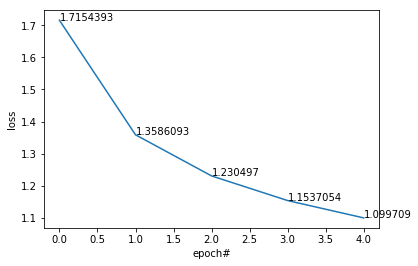

In [14]:
x = range(len(epoch_losses))
y = epoch_losses
plt.plot(x,y)
plt.xlabel("epoch#")
plt.ylabel("loss")
for a,b in zip(x, y): 
    plt.text(a, b, b)
plt.show()

Generate midi files using http://mandolintab.net/abcconverter.php  by pasting a sample from start to end.